# Triaxial $\theta_E$ VS spherical $\theta_E$ for a selected sample from the TNG100 simulation - results


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import corner

from cycler import cycler
import matplotlib as mpl
clist = ['#04B2D9', '#F2B33D', '#F29966', '#F2441D', '#0486C5']
mpl.rcParams['axes.prop_cycle'] = cycler(color=clist)

from deproject.Cosmo.default_cosmo import get_default_lens_cosmo

## Access data

In [2]:
data_oblate = np.load('./data_tng100_rmproj_oblate.npy')
data_prolate = np.load('./data_tng100_rmproj_prolate.npy')

# use default cosmology
lens_cosmo = get_default_lens_cosmo()

# add sigma bias
def add_sigma_bias(data, lens_cosmo):
    # compute bias in sigma_sis
    sigma_sis = lens_cosmo.sis_theta_E2sigma_v(theta_E = data[1, :])
    bias_sigma = sigma_sis / data[0, :] - 1
    data = np.insert(data, 2, bias_sigma, axis=0)
    return data

data_oblate = add_sigma_bias(data_oblate, lens_cosmo)
data_prolate = add_sigma_bias(data_prolate, lens_cosmo)

## plot full data

In [3]:
def corner_plot_data(data):
    
    data_plot = deepcopy(data)
    data_plot[4, :] = np.cos(data_plot[4, :])

    hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': 'green', 'data_kwargs': {'ms': 4}}

    fig = corner.corner(data_plot.T,  labels=[r'$\sigma_\mathrm{random}$',r'$\theta_E$', r'$b_\sigma$','e', r'$\cos\theta$', r'$\phi$'], label_kwargs={'fontsize': 24}, **hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True})

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=18)

    plt.show()

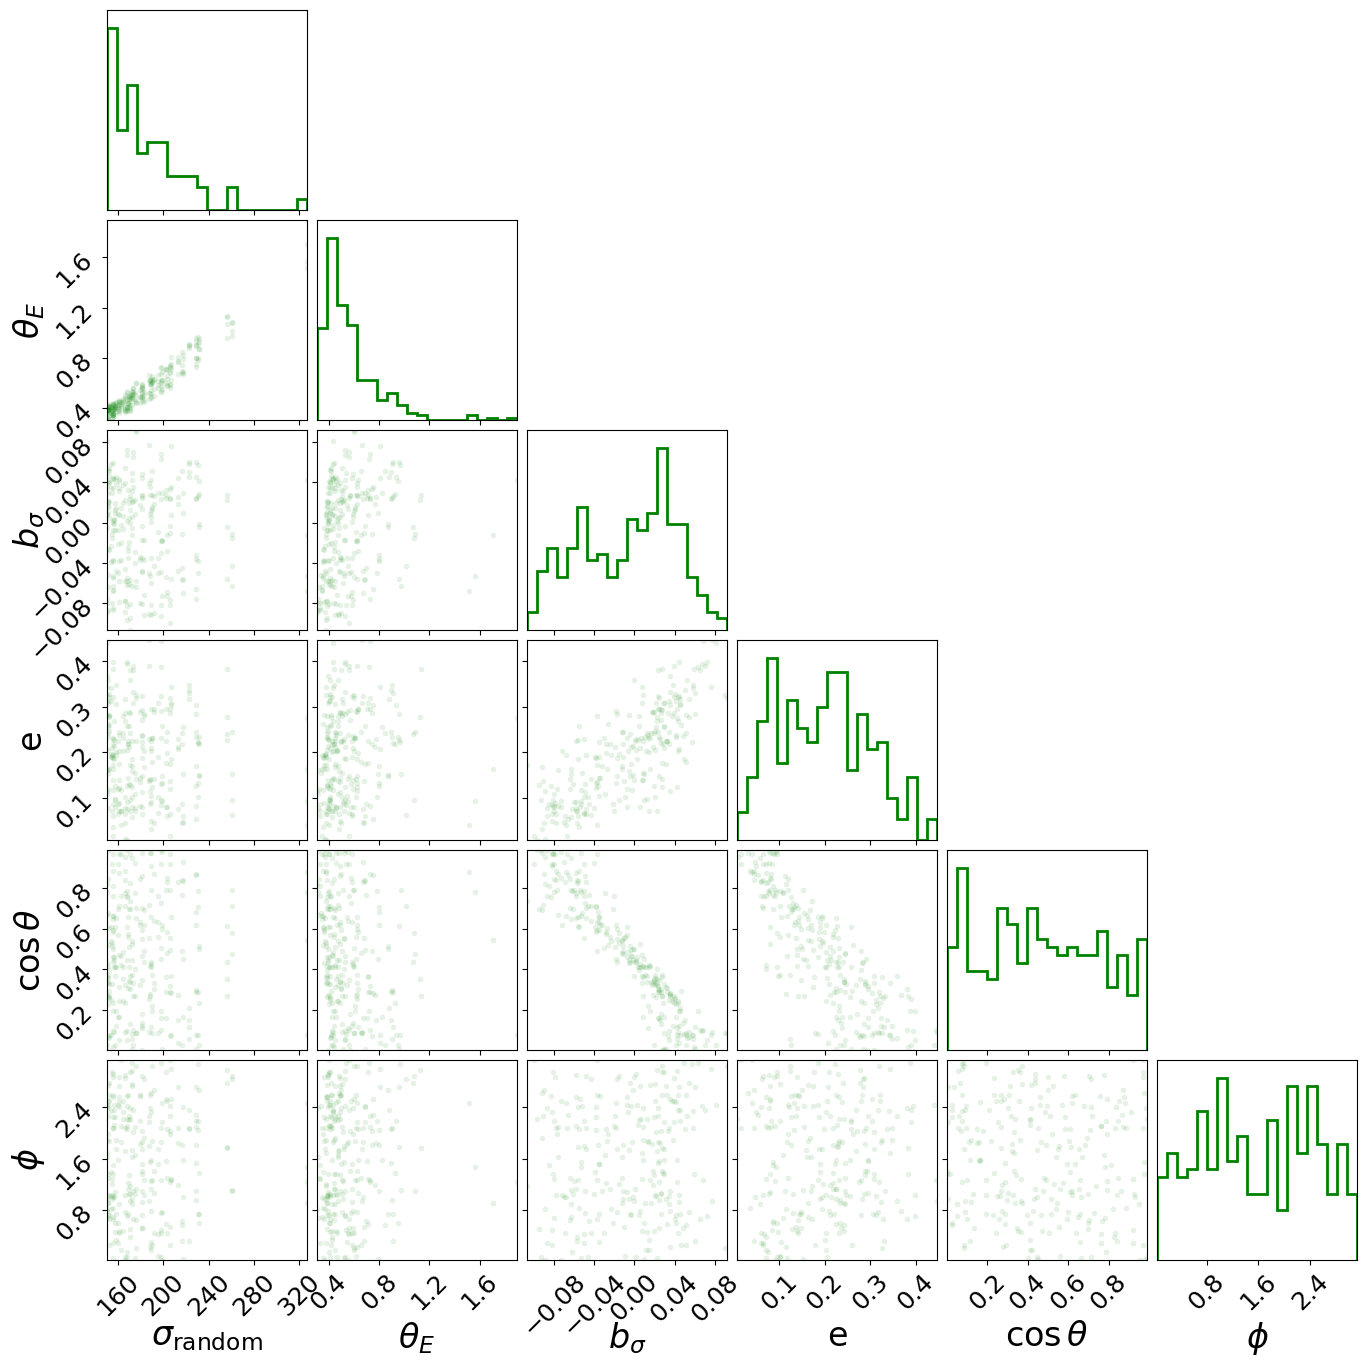

In [4]:
corner_plot_data(data_oblate)

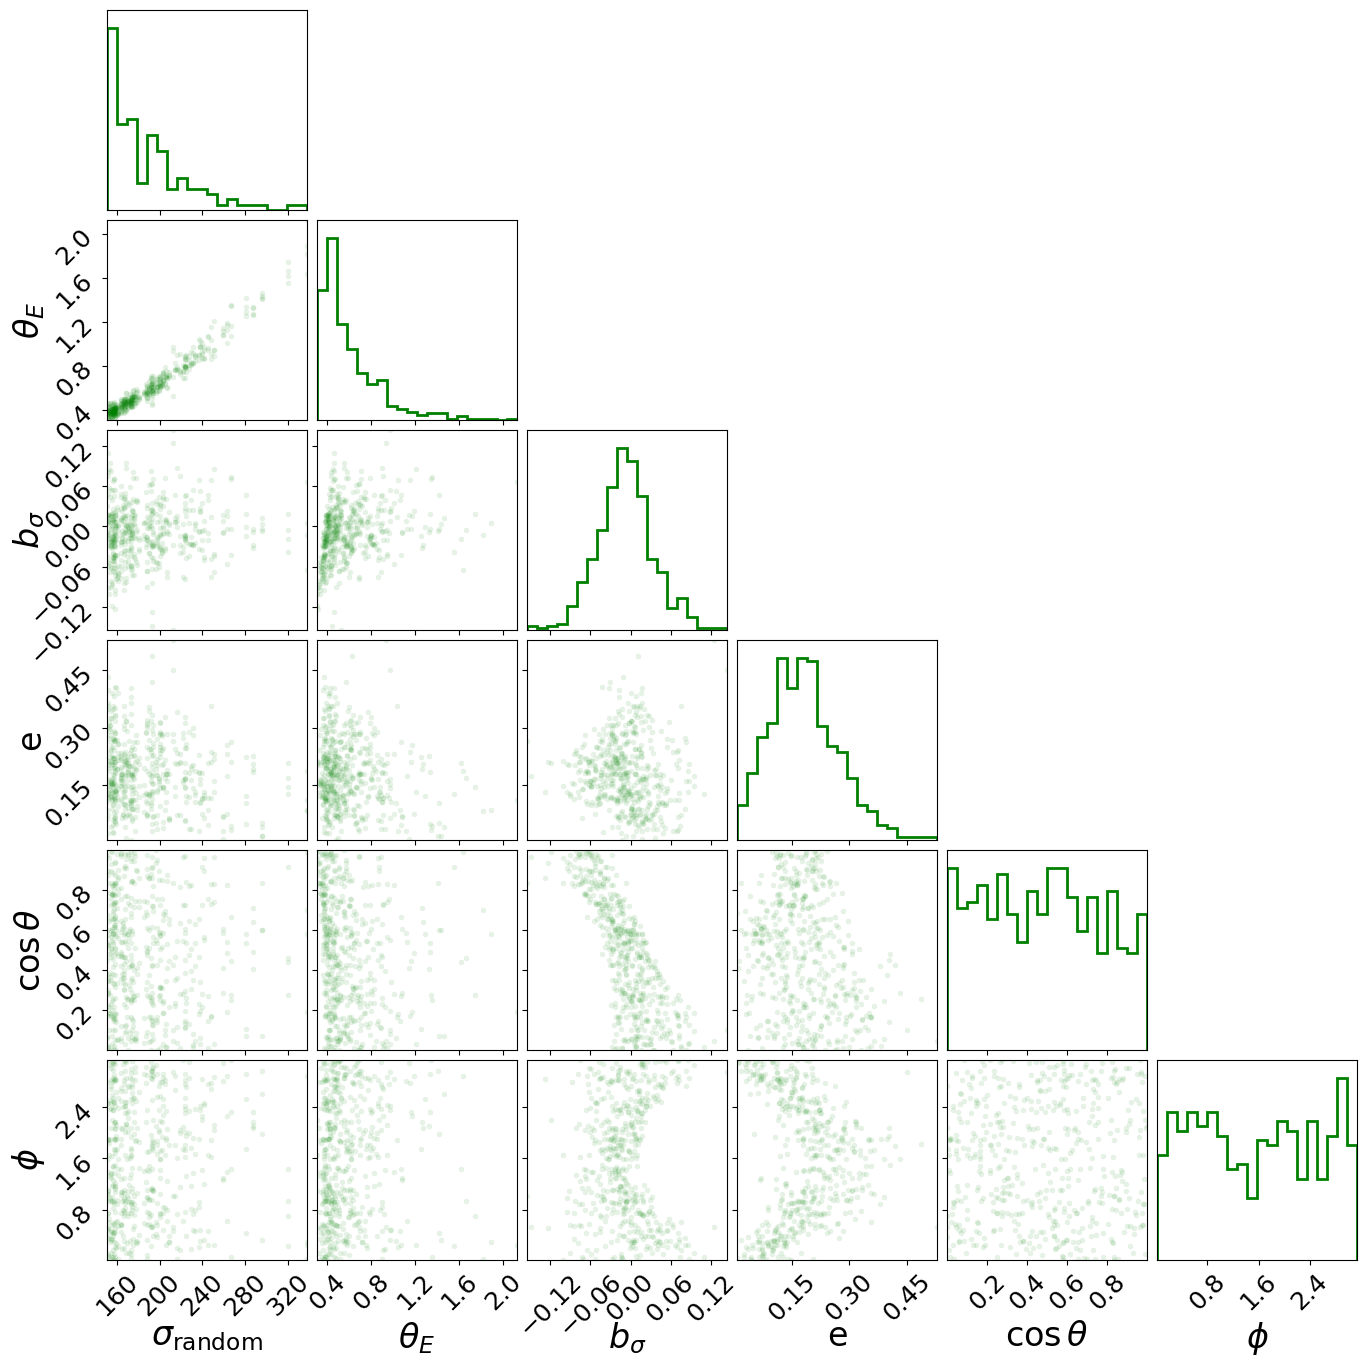

In [5]:
corner_plot_data(data_prolate)

## Apply cross section weighting

In [6]:
def corner_plot_data_weighted(data):

    data_plot = deepcopy(data)
    data_plot[4, :] = np.cos(data_plot[4, :])

    weights = data_plot[1, :] ** 2

    color_unweighted = clist[0]
    color_weighted = clist[2]

    hist2dkwargs = {
        "plot_density": False,
        "plot_contours": False,
        "plot_datapoints": True,
        "color": color_unweighted,
        "data_kwargs": {"ms": 4},
    }

    fig = corner.corner(
        data_plot.T,
        labels=[
            r"$\sigma_\mathrm{random}$",
            r"$\theta_E$",
            r"$b_\sigma$",
            "e",
            r"$\cos\theta$",
            r"$\phi$",
        ],
        label_kwargs={"fontsize": 24},
        **hist2dkwargs,
        hist_kwargs={"linewidth": 2, "density": True}
    )

    weight_hist2dkwargs = {
        "plot_density": False,
        "plot_contours": False,
        "plot_datapoints": True,
        "color": color_weighted,
        "data_kwargs": {"ms": 5, "alpha": 0.3},
    }

    corner.corner(
        data_plot.T,
        fig=fig,
        weights=weights,
        **weight_hist2dkwargs,
        hist_kwargs={"linewidth": 2, "density": True}
    )

    for ax in fig.get_axes():
        ax.tick_params(axis="both", labelsize=18)

    print("weighted mean ellipticity: ", np.average(data_plot[3, :], weights=weights))
    print("unweighted mean ellipticity: ", np.average(data_plot[3, :]))

    mean_bias_weighted = np.average(data_plot[2, :], weights=weights)
    mean_bias_unweighted = np.average(data_plot[2, :])

    axes = np.array(fig.axes).reshape((6, 6))
    line_bias_unweighted = axes[2, 2].axvline(
        mean_bias_unweighted,
        color=color_unweighted,
        linewidth=2,
        ls="--",
        label=r"mean bias $\langle b_\sigma \rangle$ unweighted",
        marker=" ",
    )
    line_bias_weighted = axes[2, 2].axvline(
        mean_bias_weighted,
        color=color_weighted,
        linewidth=2,
        ls="--",
        label=r"$\langle b_\sigma \rangle$ weighted by $\theta_E^2$",
        marker=" ",
    )

    (dummy_line1,) = axes[0, 0].plot(
        [],
        [],
        lw=2,
        ls="-",
        color=color_unweighted,
        label="random projection",
        marker=" ",
    )
    (dummy_line2,) = axes[0, 0].plot(
        [],
        [],
        lw=2,
        ls="-",
        color=color_weighted,
        label=r"with $\theta_E^2$ weighting",
        marker=" ",
    )

    fig.legend(
        handles=[dummy_line1, dummy_line2, line_bias_unweighted, line_bias_weighted],
        bbox_to_anchor=(0.0, 0.9, 0.95, 0),
        fontsize=24,
        frameon=False,
    )

    plt.show()

weighted mean ellipticity:  0.20425222205965432
unweighted mean ellipticity:  0.19646098026586947


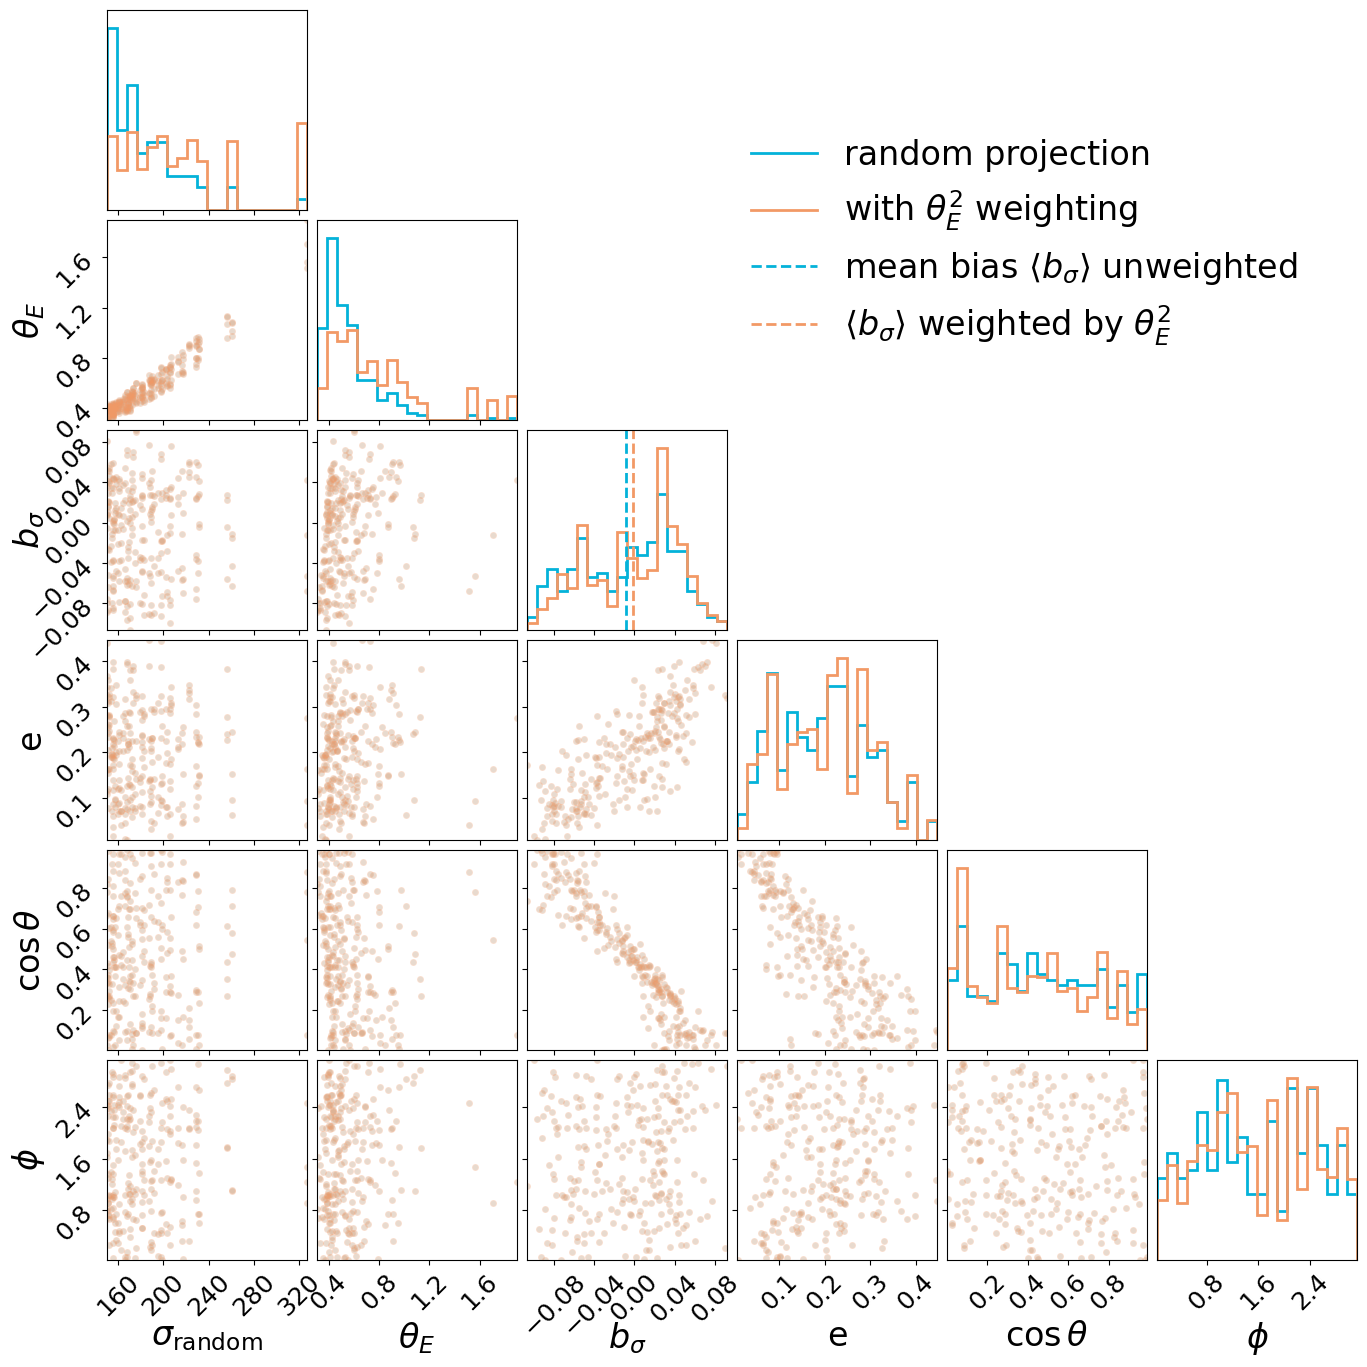

In [7]:
corner_plot_data_weighted(data_oblate)

weighted mean ellipticity:  0.16406123426270555
unweighted mean ellipticity:  0.18173024658706893


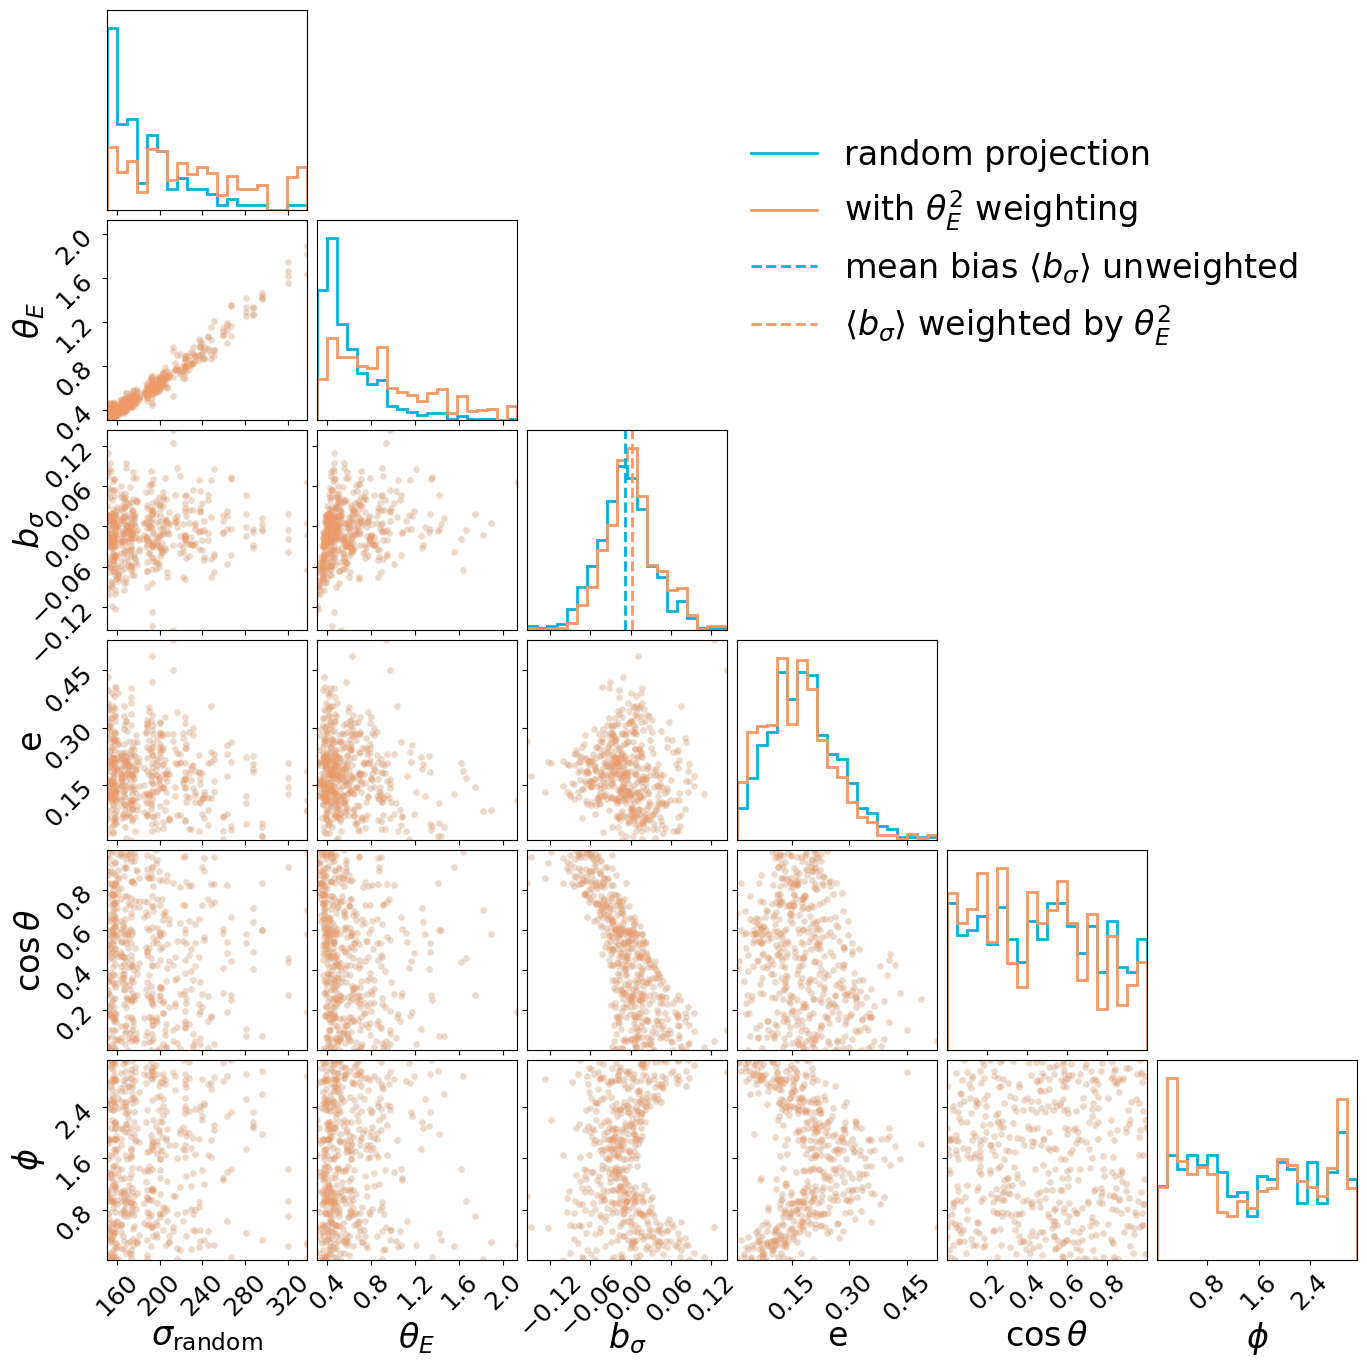

In [8]:
corner_plot_data_weighted(data_prolate)

## Plot oblate and prolate in one figure

In [9]:
def corner_plot_both(data_oblate, data_prolate):

    # clist = ['#17becf', '#8cba51', '#ff6f61', 'mediumpurple']
    clist = ["#04B2D9", "#8cba51", "coral", "mediumpurple"]
    handles = []
    sample_name = ["oblate", "prolate"]

    for j, data in enumerate([data_oblate, data_prolate]):

        data_plot = deepcopy(data)
        data_plot[4] = np.cos(data_plot[4])

        color_unweighted = clist[2 * j]
        color_weighted = clist[2 * j + 1]

        weights = data_plot[1, :] ** 2

        hist2dkwargs = {
            "plot_density": False,
            "plot_contours": False,
            "plot_datapoints": True,
            "color": color_unweighted,
            "data_kwargs": {"ms": 5, "alpha": 0.2},
        }

        if j == 0:
            fig = corner.corner(
                data_plot.T,
                labels=[
                    r"$\sigma_\mathrm{rm}$ [km/s]",
                    r"$\theta_E$ [arcsec]",
                    r"$b_\sigma$",
                    "e",
                    r"$\cos\theta$",
                    r"$\phi$",
                ],
                label_kwargs={"fontsize": 24},
                **hist2dkwargs,
                hist_kwargs={
                    "linewidth": 2,
                    "density": True,
                    "alpha": 0.8,
                    # "histtype": "bar",
                    "edgecolor": color_unweighted,
                },
                bins=10
            )
        else:
            corner.corner(
                data_plot.T,
                fig=fig,
                labels=[
                    r"$\sigma_\mathrm{rm}$ [km/s]",
                    r"$\theta_E$ [arcsec]",
                    r"$b_\sigma$",
                    "e",
                    r"$\cos\theta$",
                    r"$\phi$",
                ],
                label_kwargs={"fontsize": 24},
                **hist2dkwargs,
                hist_kwargs={
                    "linewidth": 2,
                    "density": True,
                    "alpha": 0.8,
                    # "histtype": "bar",
                    "edgecolor": color_unweighted,
                },
                bins=10
            )

        for ax in fig.get_axes():
            ax.tick_params(axis="both", labelsize=16)


        cut_hist2dkwargs = {
            "plot_density": False,
            "plot_contours": False,
            "plot_datapoints": True,
            "color": color_weighted,
            "data_kwargs": {"ms": 5, "alpha": 0.3},
        }

        corner.corner(
            data_plot.T,
            fig=fig,
            weights=weights,
            **cut_hist2dkwargs,
            hist_kwargs={
                "linewidth": 2,
                "density": True,
                "alpha": 0.8,
                # "histtype": "bar",
                "edgecolor": color_weighted,
            },
            bins=10
        )

        mean_bias_unweighted = np.average(data_plot[2, :])
        mean_bias_weighted = np.average(data_plot[2, :], weights=weights)

        axes = np.array(fig.axes).reshape((6, 6))

        line_bias_unweighted = axes[2, 2].axvline(
            mean_bias_unweighted,
            color=color_unweighted,
            linewidth=2,
            ls="--",
            label=r"mean bias $\langle b_\sigma \rangle$ unweighted, {}".format(sample_name[j]),
            marker=" ",
        )
        line_bias_weighted = axes[2, 2].axvline(
            mean_bias_weighted,
            color=color_weighted,
            linewidth=2,
            ls="--",
            label=r"$\langle b_\sigma \rangle$ weighted by $\theta_E^2$, {}".format(sample_name[j]),
            marker=" ",
        )

        handles.append(
            axes[0, 0].plot(
                [],
                [],
                lw=2,
                ls="-",
                color=color_unweighted,
                label="random projection, {}".format(sample_name[j]),
                marker=" ",
            )[0]
        )
        handles.append(line_bias_unweighted)
        handles.append(
            axes[0, 0].plot(
                [],
                [],
                lw=2,
                ls="-",
                color=color_weighted,
                label=r"with $\theta_E^2$ weighting, {}".format(sample_name[j]),
                marker=" ",
            )[0]
        )
        handles.append(line_bias_weighted)

    fig.legend(
        handles=handles, bbox_to_anchor=(0.0, 0.92, 1., 0), fontsize=22, frameon=False
    )

    return fig

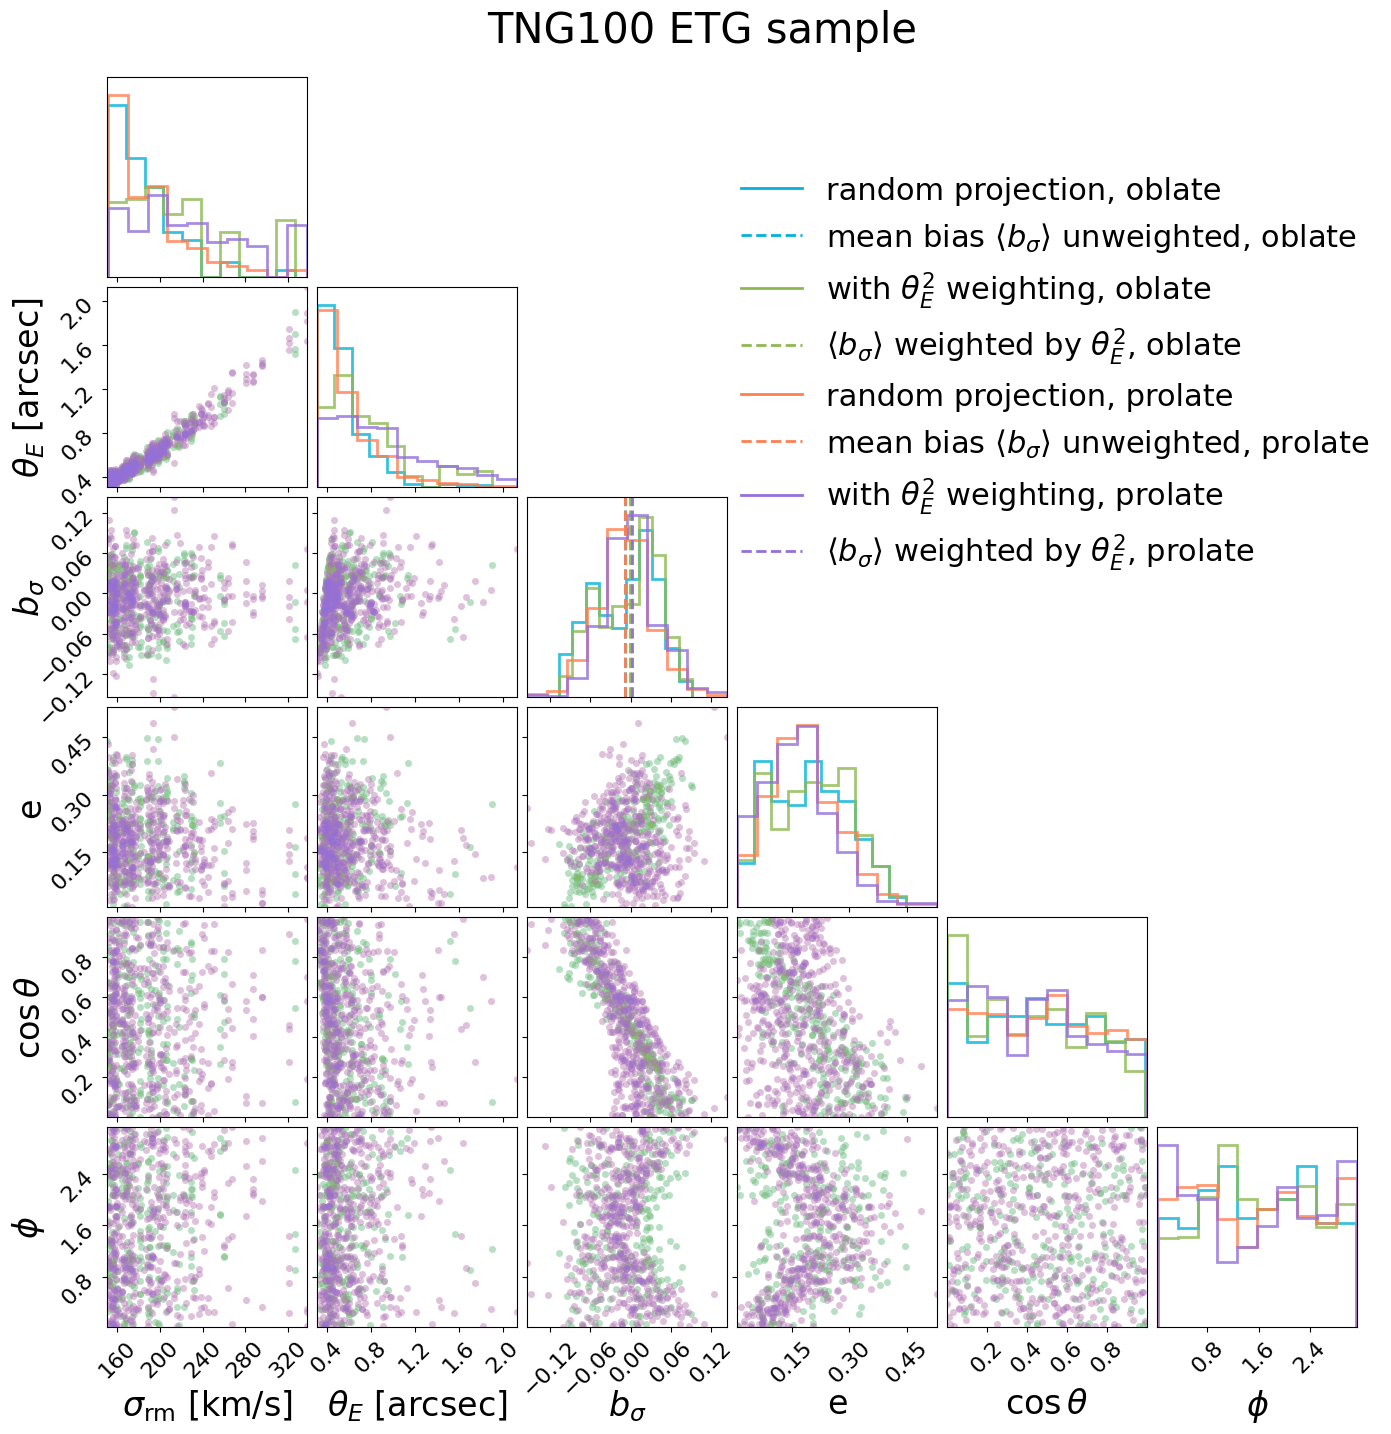

In [19]:
fig = corner_plot_both(data_oblate, data_prolate)

fig.suptitle('TNG100 ETG sample', size=30, y=1.02)
plt.savefig('../plots/tng100_rmproj_both_with_weight.pdf', dpi=300, bbox_inches='tight')

## Plot lensing cut

In [11]:
# def corner_plot_with_cut(data, theta_e_cut):

#     data_plot = deepcopy(data)
#     data_plot[4] = np.cos(data_plot[4])

#     color_all = clist[0]
#     color_cut = clist[2]

#     hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': color_all, 'data_kwargs': {'ms': 5, 'alpha': 0.2}}

#     fig = corner.corner(data_plot.T,  labels=[r'$\sigma_\mathrm{rm}$ [km/s]',r'$\theta_E$ [arcsec]', r'$b_\sigma$','e', r'$\cos\theta$', r'$\phi$'], label_kwargs={'fontsize': 24}, **hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True})

#     for ax in fig.get_axes():
#         ax.tick_params(axis='both', labelsize=16)

#     theta_e_list = data_plot[1, :]
#     ind = theta_e_list >= theta_e_cut
#     cut_data = data_plot[:, ind]

#     cut_hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': color_cut, 'data_kwargs': {'ms': 5, 'alpha': 0.3}}

#     corner.corner(cut_data.T, fig=fig, **cut_hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True})

#     mean_bias = np.mean(data[2, :])
#     mean_bias_cut = np.mean(cut_data[2, :])
    
#     axes = np.array(fig.axes).reshape((6, 6))
#     line_bias = axes[2, 2].axvline(mean_bias, color=color_all, linewidth = 2, ls = '--', label = r'mean bias $\langle b_\sigma \rangle$', marker = ' ')
#     line_bias_cut = axes[2, 2].axvline(mean_bias_cut, color=color_cut, linewidth = 2, ls = '--', label = r"$\langle b_\sigma \rangle$ with $\theta_E \geq {:.2f}$" .format(theta_e_cut) + "\"" + ' cut', marker = ' ')

#     dummy_line1, = axes[0, 0].plot([], [], lw=2, ls='-', color=color_all, label = 'random projection', marker = ' ')
#     dummy_line2, = axes[0, 0].plot([], [], lw=2, ls='-', color=color_cut, label = r"with $\theta_E \geq {:.2f}$" .format(theta_e_cut) + "\"" + " cut", marker = ' ')

#     fig.legend(handles=[dummy_line1, dummy_line2, line_bias, line_bias_cut], bbox_to_anchor=(0., 0.9, 0.95 ,0), fontsize=24, frameon=False)

#     return fig

In [12]:
# fig = corner_plot_with_cut(data_oblate, 0.6)
# fig.suptitle('oblate TNG100 ETG sample', size=30, y=1.03)
# # plt.savefig('./tng100_rmproj_oblate.pdf', dpi=300, bbox_inches='tight')

# plt.show()

In [13]:
# fig = corner_plot_with_cut(data_prolate, 0.6)
# fig.suptitle('prolate TNG100 ETG sample', size=30, y=1.03)
# # plt.savefig('./tng100_rmproj_prolate.pdf', dpi=300, bbox_inches='tight')

# plt.show()

In [14]:
data_all = np.concatenate((data_oblate, data_prolate), axis=1)

In [15]:
# fig = corner_plot_with_cut(data_all, 0.6)
# fig.suptitle('full TNG100 ETG sample', size=30, y=1.03)
# # plt.savefig('./data_lensing_selection/tng100_rmproj_all.pdf', dpi=300, bbox_inches='tight')

# plt.show()

## Plot oblate and prolate in one figure

In [16]:
# def corner_plot_both_with_cut(data_oblate, data_prolate, theta_e_cut):

#     # clist = ['#17becf', '#8cba51', '#ff6f61', 'mediumpurple']
#     clist = ['#04B2D9','#8cba51',  'coral', 'mediumpurple']
#     handles = []
#     sample_name = ['oblate', 'prolate']

#     for j, data in enumerate([data_oblate, data_prolate]):

#         data_plot = deepcopy(data)
#         data_plot[4] = np.cos(data_plot[4])

#         color_all = clist[2 * j]
#         color_cut = clist[2 * j + 1]

#         hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': color_all, 'data_kwargs': {'ms': 5, 'alpha': 0.2}}

#         if j == 0:
#             fig = corner.corner(data_plot.T, labels=[r'$\sigma_\mathrm{rm}$ [km/s]',r'$\theta_E$ [arcsec]', r'$b_\sigma$','e', r'$\cos\theta$', r'$\phi$'], label_kwargs={'fontsize': 24}, **hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True, 'alpha' : 0.8
#                                                                                                                                                                                                                         # , 'histtype': 'bar', 'edgecolor': color_all
#                                                                                                                                                                                                                         }, bins=10)
#         else:
#             corner.corner(data_plot.T,  fig = fig, labels=[r'$\sigma_\mathrm{rm}$ [km/s]',r'$\theta_E$ [arcsec]', r'$b_\sigma$','e', r'$\cos\theta$', r'$\phi$'], label_kwargs={'fontsize': 24}, **hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True, 'alpha' : 0.8
#                                                                                                                                                                                                                             #   , 'histtype': 'bar', 'edgecolor': color_all
#                                                                                                                                                                                                                               }, bins=10)

#         for ax in fig.get_axes():
#             ax.tick_params(axis='both', labelsize=16)

#         theta_e_list = data_plot[1, :]
#         ind = theta_e_list >= theta_e_cut
#         cut_data = data_plot[:, ind]

#         cut_hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': color_cut, 'data_kwargs': {'ms': 5, 'alpha': 0.3}}

#         corner.corner(cut_data.T, fig=fig, **cut_hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True, 'alpha' : 0.8
#                                                                             # , 'histtype': 'bar', 'edgecolor': color_cut
#                                                                             }, bins=10)

#         mean_bias = np.mean(data[2, :])
#         mean_bias_cut = np.mean(cut_data[2, :])
        
#         axes = np.array(fig.axes).reshape((6, 6))

    
#         line_bias = axes[2, 2].axvline(mean_bias, color=color_all, linewidth = 2, ls = '--', label = r'mean bias $\langle b_\sigma \rangle$, {}' .format(sample_name[j]), marker = ' ')
#         line_bias_cut = axes[2, 2].axvline(mean_bias_cut, color=color_cut, linewidth = 2, ls = '--', label = r"$\langle b_\sigma \rangle$ with $\theta_E \geq {:.2f}$" .format(theta_e_cut) + "\"" + ' cut, {}' .format(sample_name[j]), marker = ' ')

#         handles.append(axes[0, 0].plot([], [], lw=2, ls='-', color=color_all, label = 'random projection, {}' .format(sample_name[j]), marker = ' ')[0])
#         handles.append(line_bias)
#         handles.append(axes[0, 0].plot([], [], lw=2, ls='-', color=color_cut, label = r"with $\theta_E \geq {:.2f}$" .format(theta_e_cut) + "\"" + " cut, {}" .format(sample_name[j]), marker = ' ')[0])
#         handles.append(line_bias_cut)
        

#     fig.legend(handles=handles, bbox_to_anchor=(0., 0.9, 0.98 ,0), fontsize=22, frameon=False)

#     return fig

In [17]:
# fig = corner_plot_both_with_cut(data_oblate, data_prolate, 0.6)
# fig.suptitle('TNG100 ETG sample', size=30, y=1.03)
# plt.savefig('./tng100_rmproj_both.pdf', dpi=300, bbox_inches='tight')

## Calculate the scatter introduced by the projection effect

Quantify the scatter using: 
\begin{equation}
    \sum_j^M \left[\sqrt{\frac{\sum^N_i (\theta_{E, ij} - \langle \theta_{E,j} \rangle)^2}{(N-1)}}/ {\langle \theta_{E,j} \rangle}\right] \frac{1}{M}
\end{equation}
in percentage. $i$ represents each projection. Here $N=4$. $j$ represents each individual lens. 

In [18]:
theta_E_full = data_all[1, :]
theta_E_full = np.reshape(theta_E_full, (191, 4))
theta_E_mean = np.mean(theta_E_full, axis = 1)
# theta_E_var = np.var(theta_E_full, axis=1, ddof=1, dtype=np.float64)
theta_E_std = np.std(theta_E_full, axis=1, ddof=1, dtype=np.float64)
theta_E_scatter = theta_E_std / theta_E_mean
theta_E_scatter_mean = np.mean(theta_E_scatter)

print("mean scatter due to the projection effect: {:.3f} %" .format(theta_E_scatter_mean * 100))

mean scatter due to the projection effect: 7.802 %
